## 对数几率回归
线性回归就是基于线性模型进行回归学习，但如果想用线性模型进行分类学习的话是否可行，`对数几率回归`(`Logistic regression`, `LR`)正是这样一种线性分类模型。

### 1 对数几率回归介绍

In [9]:
import numpy as np

# sigmoid函数
def sigmoid(x):
    return 1/(1 + np.exp(-x))

sigmoid函数正好具备上述条件，单调可微，取值范围为(0,1)。且具有较好的求导特性。
$$ y=\frac{1}{1+e^{-x}}  $$
sigmoid的重要特性就是求其导函数可以用其本身来表达：
$$f'\left ( x \right ) =f(x)(1-f(x))$$

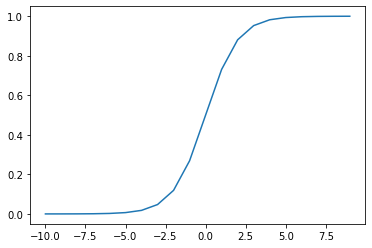

In [17]:
import matplotlib.pyplot as plt
x = np.array([x for x in range(-10,10)])
y = sigmoid(x)
plt.plot(x, y)
plt.show()

### 2 基于numpy实现对数几率回归

In [20]:
# 定义对数几率回归模型本体
def logistic(X, y, W, b):
    
    num_train = X.shape[0] # 训练样本数
    a = sigmoid(np.dot(X, W) + b) # 对数几率回归模型输出
    cost = -1 / num_train * np.sum(y * np.log(a) + (1-y) * np.log(1-a))
    dW = np.dot(X.T, (a-y)) / num_train # 权重梯度
    db = np.sum(a-y) / num_train # 偏置梯度
    cost = np.squeeze(cost) # 压缩损失数组梯度
    
    return cost, dW, db

对数几率回归模型训练

In [33]:
# 参数初始化函数
def initialize_params(dims): # w维度

    W = np.zeros((dims, 1))
    b = 0
    
    return W, b


# 定义对数几率回归模型训练
def logistic_train(X, y, learning_rate, epochs):

    num_feature = X.shape[1] # 训练特征数
    W, b = initialize_params(num_feature) # 初始化模型参数
    cost_list = [] # 损失列表
    for i in range(epochs):
        cost, dW, db = logistic(X, y, W, b) # 计算当前迭代的模型输出、损失和参数梯度
        W = W - learning_rate * dW
        b = b - learning_rate * db
        if i % 1000 == 0:
            cost_list.append(cost) # 记录损失的损失列表
        if i % 1000 == 0:
            print(f'epoch {i} cost {cost}') # 打印训练过程中的损失
        params = {'W': W, 'b': b} # 模型参数
        grads = {'dW': dW, 'db': db} # 参数梯度
    
    return params

In [23]:
# 定义预测函数
def predict(X, params):

    y_pred = sigmoid(np.dot(X, params['W']) + params['b']) # 模型预测值
    for i in range(len(y_pred)): # 基于分类阈值对概率预测值进行类别转换
        if y_pred[i] > 0.5:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    
    return y_pred

生成模拟二分类数据集

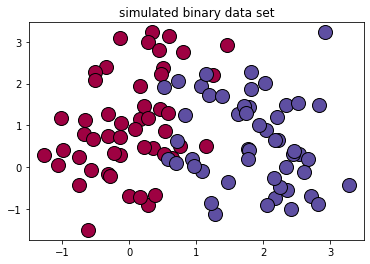

In [31]:
import matplotlib.pyplot as plt
from sklearn.datasets._samples_generator import make_classification # 导入生成分类数据函数

# 生成 100 * 2 的模拟二分类数据集
X, labels = make_classification(
    n_samples=100,
    n_features=2, # 功能总数
    n_redundant=0, # 在数据集中添加的冗余特征数量，这里设置为0，即没有冗余特征
    n_informative=2, # 在数据集中包含的信息性特征数量，这里设置为2
    random_state=1, # 确定用于生成数据集的随机数生成
    n_clusters_per_class=2 # 每个类中包含的簇数，这里设置为2
)
rng = np.random.RandomState(2) # 设置随机种子
X += 2 * rng.uniform(size=X.shape) # 对生成的特征数据增加一组均匀分布噪声
unique_labels = set(labels) # 标签集合
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels))) # 根据标签类别数设置颜色
# 绘制散点图
for k, col in zip(unique_labels, colors):
    x_k = X[labels==k]
    plt.plot(x_k[:, 0], x_k[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
plt.title('simulated binary data set')
plt.show()

构造数据集、模型训练与预测

In [35]:
from sklearn .metrics import classification_report

# 划分数据集
offset = int(X.shape[0] * 0.9)
X_train, y_train, X_test, y_test = X[:offset], labels[:offset], X[offset:], labels[offset:]
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

# 模型训练和预测
learning_rate, epochs = 0.01, 10001
params = logistic_train(X_train, y_train, learning_rate, epochs) # 训练
y_pred = predict(X_test, params) # 预测

# 测试集上的分类准确率评估
print(f'{classification_report(y_test, y_pred)}') # support 每个标签的出现次数

epoch 0 cost 0.6931471805599454
epoch 1000 cost 0.31215696018042577
epoch 2000 cost 0.26211273453687317
epoch 3000 cost 0.24055443335843807
epoch 4000 cost 0.22859534676572285
epoch 5000 cost 0.22110666873197263
epoch 6000 cost 0.21605829108403707
epoch 7000 cost 0.21247936564510303
epoch 8000 cost 0.20984745526179827
epoch 9000 cost 0.2078572559163575
epoch 10000 cost 0.20631901487039853
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



绘制对数几率回归分类决策边界

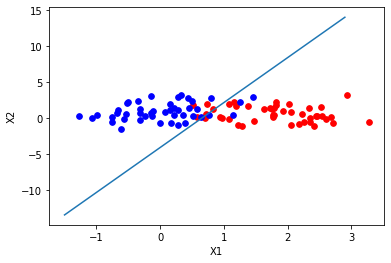

In [43]:
# 绘制对数几率回归分类决策边界
def plot_decision_boundary(X_train, y_train, params):

    n = X_train.shape[0] # 训练样本量
    # 初始化类别坐标点列表
    xcord1 = []
    ycord1 = []
    xcord2 = []
    ycord2 = []
    # 获取两类坐标点并存入列表
    for i in range(n):
        if y_train[i] == 1:
            xcord1.append(X_train[i][0])
            ycord1.append(X_train[i][1])
        else:
            xcord2.append(X_train[i][0])
            ycord2.append(X_train[i][1])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    # 绘制两类散点，以不同颜色展示
    ax.scatter(xcord1, ycord1, s=32, c='red')
    ax.scatter(xcord2, ycord2, s=32, c='blue')
    x = np.arange(-1.5, 3, 0.1) # 取值范围
    y = (-params['b'] - params['W'][0] * x) / params['W'][1] # 用决策边界公式画出决策边界
    ax.plot(x, y)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

plot_decision_boundary(X_train, y_train, params)